In [18]:
# loads model + val/test set, evaluates accuracy

import torch
from model import build_model_r3d_18  # replace with actual class name
from dataset import ClipDataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



In [15]:
# ========== SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
test_csv_path = "/home/atupulazi/personal_projects/collision-detection/frames/test/test_clip_labels.csv"  # <-- update if different
test_dataset = ClipDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [16]:
# Load model
model = build_model_r3d_18()  # Replace with your model class
model.load_state_dict(torch.load("/home/atupulazi/personal_projects/collision-detection/src/checkpoints/r3d18_final.pth"))  # Your .pth file here
model.to(device)
model.eval()


VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [17]:
# ========== TEST LOOP ==========
all_preds = []
all_labels = []

with torch.no_grad():
    for clips, labels in test_loader:
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(classification_report(
    all_preds.cpu().numpy(),
    all_labels.cpu().numpy(),
    target_names=['no_crash', 'crash']
))

              precision    recall  f1-score   support

    no_crash       0.78      0.72      0.75        86
       crash       0.70      0.76      0.73        74

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160



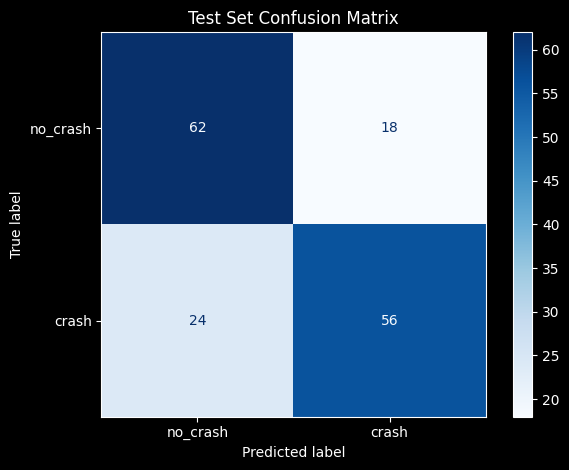

In [19]:
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no_crash", "crash"])

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Test Set Confusion Matrix")
plt.tight_layout()
plt.show()